In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline
import os
import seaborn as sns
import statsmodels.api as sm

from scipy import stats
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing

from sklearn.model_selection import cross_val_score
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

import plotly.graph_objects as go


In [2]:
df = pd.read_csv('rbess_features_val.csv', index_col = 'accounts addresses')

In [3]:
df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,predictor
accounts addresses,,,,,,,,,,,,,,,,
103,257.60,252.63,277.98,276.22,281.88,280.55,34,32541,176525,526.11,532.89,476.92,490.43,451.38,471.29,1
616,126.85,111.16,265.39,267.40,280.57,279.35,3,1897,92166,331.61,328.51,471.94,489.86,456.02,474.70,1
9,267.50,268.45,280.59,278.13,281.85,280.47,94,69558,210184,469.86,491.67,457.03,474.64,452.14,471.63,1
424,50.32,458.47,273.52,271.78,279.91,278.93,1,1454,78784,150.50,414.39,499.87,520.01,455.46,473.62,1
38,272.70,270.47,279.91,278.93,281.93,280.74,111,77330,214882,503.03,520.97,455.46,473.62,451.73,471.88,1


In [4]:
X = df.iloc[:, :-1]
y = df['predictor']

In [5]:
# Для оценки качества полученной классификации рассмотрим матрицу ошибок.
"""
    Функция conf_matrix для расчета TP (true positives), FP (false positives), TN (true negatives), FN (false negatives)  
    y_true: массив array, истинные отклики
    y_true: массив array, предсказанные классификатором отклики
"""

def conf_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels = ['Не мошенник', 'Мошенник'])
    disp.plot(cmap='Greens')
    plt.rcParams["axes.grid"] = False
    font = {'size' : 12}
    plt.rc('font', **font)
    plt.show()

In [6]:
"""
    Функция acc_rec для расчета метрик accuracy, recall для k-fold cross-validation  
    amount_folds: последовательность range, диапазон значений для количества фолдов
    amount_k: последовательность range, диапазон значений для значений k в модели knn
"""

def acc_rec(amount_folds, amount_k):
    result_acc, result_rec  = [], []
    for fold in amount_folds:
        score_acc = []
        score_rec = []
        skf = StratifiedKFold(n_splits=fold)
        for k in amount_k:
            clf = KNeighborsClassifier(n_neighbors = k, 
                algorithm = 'auto',   #  как искать ближайших соседей?
                leaf_size = 30,       #  параметр  BallTree или KDTree
                metric = 'minkowski', #  расстояние между объектами
                p = 2,                #  так расст. Минковского  превращается в евклидово
                weights = 'distance')  # одинаковые веса классов
            pipeline = make_pipeline(preprocessing.StandardScaler(), clf)
            score_acc.append(cross_val_score(pipeline, X, y, cv=skf, scoring= 'accuracy').mean())
            score_rec.append(cross_val_score(pipeline, X, y, cv=skf, scoring= 'recall_macro').mean())
            
        result_acc.append(score_acc)
        result_rec.append(score_rec)
    return result_acc, result_rec

In [22]:
amount_folds = range(4,10)
amount_k = range(1, 10)
result_acc,  result_rec = acc_rec(amount_folds, amount_k)[0], acc_rec(amount_folds, amount_k)[1]

In [23]:
fig= go.Figure() 
for ind, fold in enumerate(amount_folds):
    fig.add_scatter(x=np.array(amount_k), y=result_acc[ind], mode="lines", name =f"folds = {fold}")
fig.update_layout(width=950, title="Accuracy score with cv", 
                  xaxis_title="Amount of nearest neighbours in kNN", yaxis_title="Accuracy") 
fig.show()    

In [24]:
fig= go.Figure() 
for ind, fold in enumerate(amount_folds):
    fig.add_scatter(x=np.array(amount_k), y=result_rec[ind], mode="lines", name =f"folds = {fold}")
fig.update_layout(width=950, title="Recall score with cv", 
                  xaxis_title="Amount of nearest neighbours in kNN", yaxis_title="Recall") 
fig.show()    

### Подбор гиперпараметров

In [13]:
# Разделяем на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 21, stratify = y)

# clf = KNeighborsClassifier(algorithm='auto')

from sklearn.pipeline import make_pipeline, Pipeline
estimator_KNN = Pipeline([('scaler', preprocessing.StandardScaler()),
                               ('kNN', KNeighborsClassifier()) ])


In [14]:
parameters_KNN = {
    'kNN__n_neighbors': (1,2,3,4,5,6 ),
#     'leaf_size': (20,40,1, 30,10),
    'kNN__p': (1,2),
    'kNN__weights': ('uniform', 'distance'),
    'kNN__metric': ('minkowski', 'chebyshev')}


grid_CV = GridSearchCV(
    estimator=estimator_KNN,
    param_grid=parameters_KNN,
    scoring = 'f1_macro',
    cv = StratifiedKFold(n_splits=5)
)
grid_CV.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('kNN', KNeighborsClassifier())]),
             param_grid={'kNN__metric': ('minkowski', 'chebyshev'),
                         'kNN__n_neighbors': (1, 2, 3, 4, 5, 6),
                         'kNN__p': (1, 2),
                         'kNN__weights': ('uniform', 'distance')},
             scoring='f1_macro')

In [15]:
#   Лучший набор значений гиперпараметров
best_hyperparams = grid_CV.best_params_
print('Лучшие значения гиперпараметров:\n', best_hyperparams)

best_model = grid_CV.best_estimator_

y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

Лучшие значения гиперпараметров:
 {'kNN__metric': 'minkowski', 'kNN__n_neighbors': 2, 'kNN__p': 1, 'kNN__weights': 'distance'}


На тестовой выборке:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       428
           1       0.04      0.05      0.05        19

    accuracy                           0.91       447
   macro avg       0.50      0.50      0.50       447
weighted avg       0.92      0.91      0.91       447



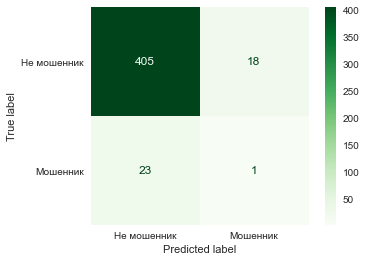

In [17]:
print('На тестовой выборке:')
print(classification_report(y_pred_test, y_test))
conf_matrix(y_test, y_pred_test)

### Подбор гиперпараметров на части признаков

In [18]:
df_copy = df.copy()
feature_set = [str(x) for x in df.iloc[:, :-1].columns if int(x[-1]) % 2 == 0 ]
df_copy = pd.concat([df_copy.loc[:, feature_set], df_copy['predictor']], axis = 1)
X_copy = df_copy.iloc[:, :-1]
y_copy = df_copy['predictor']
# Разделим на обучающую и тестовую выборки
# При построении леса, как и деревьев, стандартизация не нужна, сразу разделяем на обучающую и тестовую
X_train_copy, X_test_copy, y_train_copy, y_test_copy = train_test_split(X_copy, y_copy , random_state = 21, test_size = 0.33, stratify = y)

In [19]:
parameters_KNN = {
    'kNN__n_neighbors': (1,2,3,4,5,6 ),
#     'leaf_size': (20,40,1, 30,10),
    'kNN__p': (1,2),
    'kNN__weights': ('uniform', 'distance'),
    'kNN__metric': ('minkowski', 'chebyshev')}


grid_CV = GridSearchCV(
    estimator=estimator_KNN,
    param_grid=parameters_KNN,
    scoring = 'f1_macro',
    cv = StratifiedKFold(n_splits=5)
)
grid_CV.fit(X_train_copy, y_train_copy)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('kNN', KNeighborsClassifier())]),
             param_grid={'kNN__metric': ('minkowski', 'chebyshev'),
                         'kNN__n_neighbors': (1, 2, 3, 4, 5, 6),
                         'kNN__p': (1, 2),
                         'kNN__weights': ('uniform', 'distance')},
             scoring='f1_macro')

In [20]:
#   Лучший набор значений гиперпараметров
best_hyperparams = grid_CV.best_params_
print('Лучшие значения гиперпараметров:\n', best_hyperparams)

best_model = grid_CV.best_estimator_

y_pred_train_copy = best_model.predict(X_train_copy)
y_pred_test_copy = best_model.predict(X_test_copy)

Лучшие значения гиперпараметров:
 {'kNN__metric': 'minkowski', 'kNN__n_neighbors': 3, 'kNN__p': 1, 'kNN__weights': 'distance'}


На тестовой выборке:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       440
           1       0.04      0.14      0.06         7

    accuracy                           0.94       447
   macro avg       0.51      0.55      0.52       447
weighted avg       0.97      0.94      0.95       447



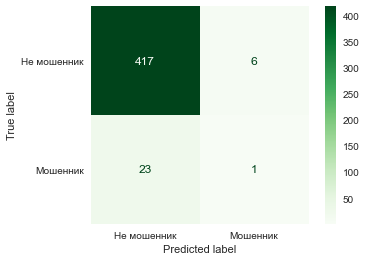

In [21]:
print('На тестовой выборке:')
print(classification_report(y_pred_test_copy, y_test))
conf_matrix(y_test, y_pred_test_copy)